In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !export PYTHONPATH=/Users/piyush/projects/ViDA-SSL/
import sys
sys.path.append("/Users/piyush/projects/ViDA-SSL/")

In [32]:
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

import torch
from fast_pytorch_kmeans import KMeans
from transformers import AutoTokenizer, AutoModel

from misc.local_utils import get_phrase_embedding
from utils.viz import bokeh_2d_scatter, bokeh_2d_scatter_new
from datasets.ntu import NTU
from datasets.epic import EPIC
from datasets.something_something import SomethingSomething
from datasets.finegym import FineGym
from datasets.ucf import UCF
from datasets.kinetics import Kinetics

### Load all dataset labels

In [4]:
datasets = [
    {
        "name": "Kinetics",
        "args": {"data_dir": "../data/Kinetics-400/"},
        "color": "limegreen",
        "filename": "kinetics_400_labels.csv",
    },
    {
        "name": "UCF",
        "args": {"data_dir": "../data/UCF-101/"},
        "color": "red",
        "filename": "classes_cleaned.txt",
    },
    {
        "name": "NTU",
        "args": {"data_dir": "../data/NTU/"},
        "color": "blue",
        "filename": "class_labels.txt",
    },
    {
        "name": "SomethingSomething",
        "args": {"data_dir": "../data/Something-Something/"},
        "color": "yellow",
        "filename": "fine_grained_classes_cleaned.csv",
    },
    {
        "name": "FineGym",
        "args": {"data_dir": "../data/FineGym/"},
        "color": "gray",
        "filename": "gym99_categories_cleaned.txt",
    },
    {
        "name": "EPIC",
        "args": {"data_dir": "../data/EPIC-KITCHENS-100/"},
        "color": "magenta",
        "filename": "EPIC_100_verb_classes.csv",
    },
]

In [5]:
all_dataset_labels = dict()

for datadict in datasets:
    df = pd.DataFrame(None)

    dataset = eval(f"{datadict['name']}(**{datadict['args']})")
    class_label_dict = dataset._load_annotations(filename=datadict["filename"])
    all_dataset_labels[datadict["name"]] = class_label_dict

In [108]:
all_dataset_labels.keys()

dict_keys(['Kinetics', 'UCF', 'NTU', 'SomethingSomething', 'FineGym', 'EPIC'])

#### Apply `Flair` on a sample action label

In [113]:
kinetics_labels = all_dataset_labels["Kinetics"]

In [114]:
action = kinetics_labels[10]

In [115]:
from flair.data import Sentence
from flair.models import SequenceTagger

In [116]:
# load tagger
tagger = SequenceTagger.load("flair/pos-english")

2021-10-16 14:39:24,180 loading file /Users/piyush/.flair/models/pos-english/a9a73f6cd878edce8a0fa518db76f441f1cc49c2525b2b4557af278ec2f0659e.121306ea62993d04cd1978398b68396931a39eb47754c8a06a87f325ea70ac63


In [117]:
# make example sentence
sentence = Sentence(action)

In [118]:
# predict NER tags
tagger.predict(sentence)

# print sentence
print(sentence)

Sentence: "baby waking up"   [− Tokens: 3  − Token-Labels: "baby <NN> waking <VBG> up <RP>"]


In [119]:
entities = sentence.get_spans('pos')

In [120]:
all_tag_values = []
all_tags = []

for et in entities:
    tags = [tag.to_dict() for tag in et.labels]
    tag_values = [tag.value for tag in et.labels]
    all_tag_values.extend(tag_values)
    all_tags.extend(tags)

### Extract `Kinetics-400` labels (or any other dataset)

In [165]:
dataset_key = "EPIC"

In [166]:
labels = all_dataset_labels[dataset_key]

In [167]:
def get_pos_tags_in_action_class(action):
    sentence = Sentence(action)
    tagger.predict(sentence)
    
    entities = sentence.get_spans('pos')

    all_tag_values = []
    all_tags = []

    for et in entities:
        tags = [tag.to_dict() for tag in et.labels]
        tag_values = [tag.value for tag in et.labels]
        all_tag_values.extend(tag_values)
        all_tags.extend(tags)
    
    return all_tag_values

In [168]:
get_pos_tags_in_action_class(action)

['NN', 'VBG', 'RP']

#### Run on the entire dataset

In [169]:
pos_df = pd.DataFrame(None, index=labels.values())

In [170]:
tags_in_a_dataset = []

for (k, v) in tqdm(labels.items(), desc="Generating POS tags for dataset"):
    tags = get_pos_tags_in_action_class(v)
    for tag in tags:

        if tag not in pos_df.columns:
            pos_df[tag] = 0.0

        pos_df.at[v, tag] += 1.0

    tags_in_a_dataset.extend(tags)

Generating POS tags for dataset: 100%|████████████████████████████████████████████████████████████████| 97/97 [00:06<00:00, 15.01it/s]


In [171]:
pos_df

,VB,JJ,RB,NN,UH,JJR
take,1.0,0.0,0.0,0.0,0.0,0.0
put,1.0,0.0,0.0,0.0,0.0,0.0
wash,1.0,0.0,0.0,0.0,0.0,0.0
open,0.0,1.0,0.0,0.0,0.0,0.0
close,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
prepare,1.0,0.0,0.0,0.0,0.0,0.0
bake,0.0,0.0,0.0,1.0,0.0,0.0
mark,0.0,0.0,0.0,1.0,0.0,0.0
bend,0.0,0.0,0.0,1.0,0.0,0.0


In [177]:
tag_meanings = pd.read_csv("flair_pos_tag_meanings.csv", delimiter="\t")
tag_meanings = dict(tag_meanings[["tag", "meaning"]].values)

In [178]:
tag_meanings

{'ADD': 'Email',
 'AFX': 'Affix',
 'CC': 'Coordinating conjunction',
 'CD': 'Cardinal number',
 'DT': 'Determiner',
 'EX': 'Existential there',
 'FW': 'Foreign word',
 'HYPH': 'Hyphen',
 'IN': 'Preposition or subordinating conjunction',
 'JJ': 'Adjective',
 'JJR': 'Adjective, comparative',
 'JJS': 'Adjective, superlative',
 'LS': 'List item marker',
 'MD': 'Modal',
 'NFP': 'Superfluous punctuation',
 'NN': 'Noun, singular or mass',
 'NNP': 'Proper noun, singular',
 'NNPS': 'Proper noun, plural',
 'NNS': 'Noun, plural',
 'PDT': 'Predeterminer',
 'POS': 'Possessive ending',
 'PRP': 'Personal pronoun',
 'PRP$': 'Possessive pronoun',
 'RB': 'Adverb',
 'RBR': 'Adverb, comparative',
 'RBS': 'Adverb, superlative',
 'RP': 'Particle',
 'SYM': 'Symbol',
 'TO': 'to',
 'UH': 'Interjection',
 'VB': 'Verb, base form',
 'VBD': 'Verb, past tense',
 'VBG': 'Verb, gerund or present participle',
 'VBN': 'Verb, past participle',
 'VBP': 'Verb, non-3rd person singular present',
 'VBZ': 'Verb, 3rd person si

In [173]:
threshold = 2
sub_pos_df = pos_df.loc[pos_df.index, (pos_df.sum() >= threshold)]
sub_pos_df = sub_pos_df.rename(columns=tag_meanings)

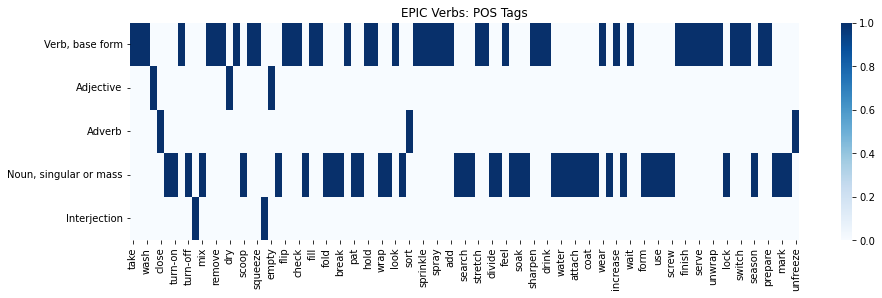

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
sns.heatmap(data=sub_pos_df.T, cmap="Blues", ax=ax)

plt.title(f"{dataset_key} Verbs: POS Tags")
plt.show()

### Doing it for all datasets

In [184]:
dfs = []

for i, dataset_key in enumerate(all_dataset_labels.keys()):
    labels = all_dataset_labels[dataset_key]
    
    pos_df = pd.DataFrame(0.0, index=labels.values(), columns=list(tag_meanings.keys()))

    tags_in_a_dataset = []

    for (k, v) in tqdm(labels.items(), desc=f"Generating POS tags for {dataset_key}"):
        tags = get_pos_tags_in_action_class(v)
        for tag in tags:

            if tag not in pos_df.columns:
                pos_df[tag] = 0.0

            pos_df.at[v, tag] += 1.0

        tags_in_a_dataset.extend(tags)

    dfs.append(sub_pos_df)

    # sub_pos_df = sub_pos_df.rename(columns=tag_meanings)
    
#     sns.heatmap(data=sub_pos_df, cmap="Blues", ax=ax[i])
    
#     ax[i].set_yticks([])
#     if i != (len(all_dataset_labels) - 1):
#         ax[i].set_xticks([])

#     ax[i].set_title(f"{dataset_key} Verbs: POS Tags")

# plt.show()

Generating POS tags for EPIC: 100%|███████████████████████████████████████████████████████████████████| 97/97 [00:07<00:00, 13.81it/s]


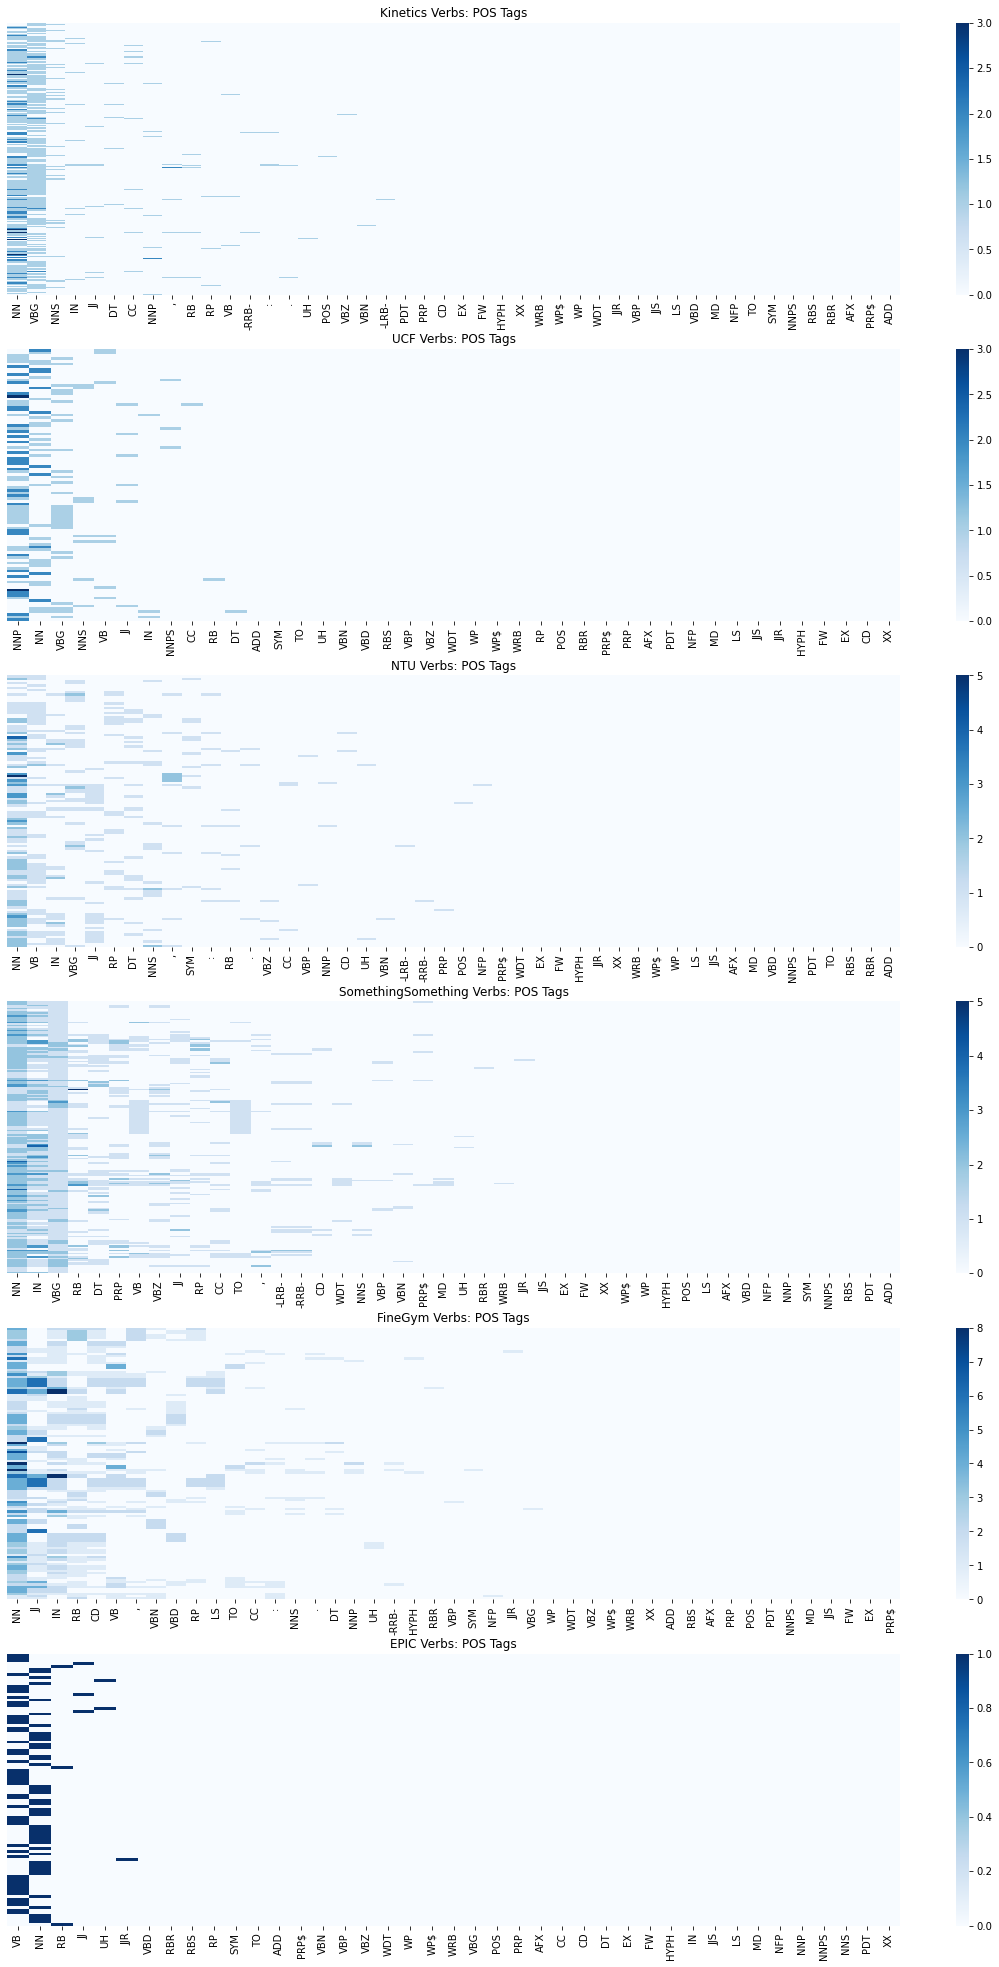

In [192]:
fig, ax = plt.subplots(len(all_dataset_labels), 1, figsize=(20, 35))

for i, dataset_key in enumerate(all_dataset_labels.keys()):
    
    df = dfs[i]
    
    # sort columns by highest total
    df = df[df.sum().sort_values(ascending = False).index]
    
    # remove columns with < threshold tags
    # threshold = 5
    # df = df.loc[df.index, (df.sum() >= threshold)]

    # rename columns
    # df = df.rename(columns=tag_meanings)

    sns.heatmap(data=df, cmap="Blues", ax=ax[i])
    
    ax[i].set_yticks([])

    # if i != (len(all_dataset_labels) - 1):
    #     ax[i].set_xticks([])

    ax[i].set_title(f"{dataset_key} Verbs: POS Tags")

plt.show()

In [189]:
tag_meanings

{'ADD': 'Email',
 'AFX': 'Affix',
 'CC': 'Coordinating conjunction',
 'CD': 'Cardinal number',
 'DT': 'Determiner',
 'EX': 'Existential there',
 'FW': 'Foreign word',
 'HYPH': 'Hyphen',
 'IN': 'Preposition or subordinating conjunction',
 'JJ': 'Adjective',
 'JJR': 'Adjective, comparative',
 'JJS': 'Adjective, superlative',
 'LS': 'List item marker',
 'MD': 'Modal',
 'NFP': 'Superfluous punctuation',
 'NN': 'Noun, singular or mass',
 'NNP': 'Proper noun, singular',
 'NNPS': 'Proper noun, plural',
 'NNS': 'Noun, plural',
 'PDT': 'Predeterminer',
 'POS': 'Possessive ending',
 'PRP': 'Personal pronoun',
 'PRP$': 'Possessive pronoun',
 'RB': 'Adverb',
 'RBR': 'Adverb, comparative',
 'RBS': 'Adverb, superlative',
 'RP': 'Particle',
 'SYM': 'Symbol',
 'TO': 'to',
 'UH': 'Interjection',
 'VB': 'Verb, base form',
 'VBD': 'Verb, past tense',
 'VBG': 'Verb, gerund or present participle',
 'VBN': 'Verb, past participle',
 'VBP': 'Verb, non-3rd person singular present',
 'VBZ': 'Verb, 3rd person si